In [1]:
import sys
sys.path.append("../")

import jax
import jax.numpy as np

from transformers import FlaxCLIPModel, AutoProcessor, AutoTokenizer

%matplotlib inline
%load_ext autoreload
%autoreload 2

2024-01-12 17:24:29.342394: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-12 17:24:29.342443: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-12 17:24:29.343675: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
model = FlaxCLIPModel.from_pretrained("openai/clip-vit-base-patch16")
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch16")
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch16")

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

from matplotlib import cm
cmap = matplotlib.colormaps.get_cmap('viridis_r')

# Ignore warning
import warnings
import logging

logging.getLogger('matplotlib').setLevel(logging.ERROR)
warnings.filterwarnings("ignore",category=matplotlib.MatplotlibDeprecationWarning)

# Get plot params

from plot_params import params
pylab.rcParams.update(params)

# Set default colors to load at will
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
import yaml
from ml_collections.config_dict import ConfigDict

logging_dir = '../logging/proposals/'
run_name = 'polar-hill-76'

config_file = "{}/{}/config.yaml".format(logging_dir, run_name)

with open(config_file, 'r') as file:
    config = yaml.safe_load(file)
    
config = ConfigDict(config)

In [5]:
import optax 
from flax.training import checkpoints, common_utils, train_state

import flax

replicate = flax.jax_utils.replicate
unreplicate = flax.jax_utils.unreplicate

schedule = optax.warmup_cosine_decay_schedule(
    init_value=0.0,
    peak_value=1e-4,
    warmup_steps=5_000,
    decay_steps=100_000,
)

tx = optax.adamw(learning_rate=schedule, weight_decay=1e-4)
state = train_state.TrainState.create(apply_fn=model.__call__, params=model.params, tx=tx)

In [6]:
import orbax

ckpt_dir = "{}/{}".format(logging_dir, run_name)  # Load SLURM run

best_fn = lambda metrics: metrics[f"val/top_10_accuracy"]

mgr_options = orbax.checkpoint.CheckpointManagerOptions(step_prefix=f'step', best_fn=best_fn, best_mode='min', create=False)
ckpt_mgr = orbax.checkpoint.CheckpointManager(f"{ckpt_dir}/ckpts/", orbax.checkpoint.Checkpointer(orbax.checkpoint.PyTreeCheckpointHandler()), mgr_options)

restore_args = flax.training.orbax_utils.restore_args_from_target(state, mesh=None)
restored_state = ckpt_mgr.restore(ckpt_mgr.latest_step(), items=state, restore_kwargs={'restore_args': restore_args})

if state is restored_state:
    raise FileNotFoundError(f"Did not load checkpoint correctly")

In [7]:
def cosine_similarity(vec1, vec2):
    
    norm_vec1 = np.linalg.norm(vec1, axis=-1,)
    norm_vec2 = np.linalg.norm(vec2, axis=-1,)
        
    return np.dot(vec1, vec2) / (norm_vec1 * norm_vec2)

In [8]:
from tqdm import tqdm
import tensorflow as tf
from utils.dataset_utils import make_dataloader, create_input_iter
from dm_pix import center_crop

In [9]:
from functools import partial
from einops import rearrange

@partial(jax.pmap, axis_name="batch")
def get_features(state, input_ids, pixel_values, attention_mask):
    captions_feat = model.get_text_features(input_ids, attention_mask, params=state.params)
    images_feat = model.get_image_features(pixel_values, params=state.params)
    return images_feat, captions_feat
    
def get_features_ds(state, ds, use_sum1=False):

    batches = iter(ds)

    image_feat_stack = []
    images_stack = []
    captions_stack = []
    captions_feat_stack = []
    
    num_local_devices = jax.local_device_count()
    replicate = flax.jax_utils.replicate
    
    total_batches = sum(1 for _ in ds) - 1
    current_batch = 0

    for (images, captions) in tqdm(batches, total=total_batches):
        if current_batch == total_batches - 1:
            break
    
        images = np.array(images)
        captions = captions.numpy().tolist()
        captions = [c.decode('utf-8') for c in captions]
        

        if use_sum1:
            captions_sum1 = []
            for caption in captions:
                sum1 = sum_merged[sum_merged['objects_phenomena_x'] == caption.split(';')[0]]['objects_phenomena_y'].values[0]
                if sum1 is np.nan:
                    sum1 = "None"
                captions_sum1 += [sum1]
                
            captions_stack += captions_sum1
        else:
            captions_stack += captions

        images_stack.append(images)
        
        images = center_crop(images, 224, 224)
        input = processor(text=captions_sum1 if use_sum1 else captions, images=(images * 255.), return_tensors="np", padding="max_length", truncation=True, max_length=77)
    
        batch = jax.tree_map(lambda x: np.split(x, num_local_devices, axis=0), input.data)
    
        image_feat, captions_feat = get_features(replicate(state), np.array(batch["input_ids"]), np.array(batch["pixel_values"]), np.array(batch["attention_mask"]))

        image_feat = rearrange(image_feat, "d b e -> (d b) e")
        captions_feat = rearrange(captions_feat, "d b e -> (d b) e")

        captions_feat_stack.append(captions_feat)
        image_feat_stack.append(image_feat)

        current_batch += 1

    return image_feat_stack, captions_feat_stack, images_stack, captions_stack

In [10]:
files = tf.io.gfile.glob(f"/n/holyscratch01/iaifi_lab/smsharma/hubble_data/tfrecords_v5/*val*.tfrecord")
ds = make_dataloader(files, batch_size=config.training.batch_size, seed=config.seed, split="val", shuffle=False, caption_type="summary")

image_feat_stack, captions_feat_stack, images_stack, captions_stack = get_features_ds(restored_state, ds)
image_base_feat_stack, captions_feat_base_stack, images_base_stack, captions_base_stack = get_features_ds(state, ds)

 99%|████████████████████████████████████████████████████████████████▎| 98/99 [00:44<00:00,  2.19it/s]


In [11]:
files = tf.io.gfile.glob(f"/n/holyscratch01/iaifi_lab/smsharma/hubble_data/tfrecords_v5/*train_9.tfrecord")
ds = make_dataloader(files, batch_size=config.training.batch_size, seed=config.seed, split="val", shuffle=False, caption_type="summary")

image_feat_train_stack, captions_feat_train_stack, images_train_stack, captions_train_stack = get_features_ds(restored_state, ds)
image_base_feat_train_stack, captions_feat_train_base_stack, images_train_base_stack, captions_train_base_stack = get_features_ds(state, ds)

 99%|████████████████████████████████████████████████████████████████▎| 98/99 [00:41<00:00,  2.38it/s]


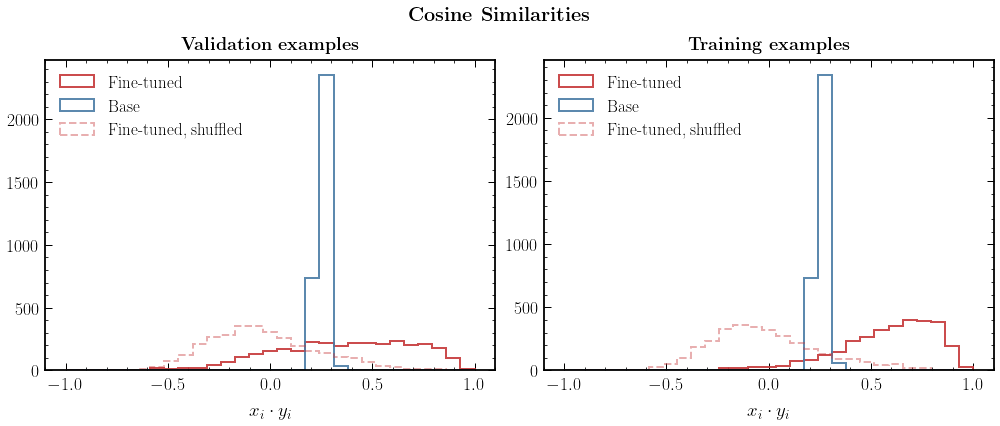

In [13]:
bins = np.linspace(-1, 1, 30)
lw = 2

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].hist(jax.vmap(cosine_similarity)(np.vstack(image_feat_stack), np.vstack(captions_feat_stack)[:]), histtype='step', label="Fine-tuned", bins=bins, lw=lw)
ax[0].hist(jax.vmap(cosine_similarity)(np.vstack(image_base_feat_stack), np.vstack(captions_feat_base_stack)), histtype='step', label="Base", bins=bins, lw=lw)
ax[0].hist(jax.vmap(cosine_similarity)(np.vstack(image_feat_stack), jax.random.permutation(jax.random.PRNGKey(42), np.vstack(captions_feat_stack)[:])), histtype='step', label="Fine-tuned, shuffled", bins=bins, lw=lw, color=cols_default[0], ls='--', alpha=0.4)

ax[0].set_xlabel("$x_i\cdot y_i$")
ax[0].legend()
ax[0].set_title(r"\textbf{Validation examples}", y=1.01)

ax[1].hist(jax.vmap(cosine_similarity)(np.vstack(image_feat_train_stack), np.vstack(captions_feat_train_stack)[:]), histtype='step', label="Fine-tuned", bins=bins, lw=lw)
ax[1].hist(jax.vmap(cosine_similarity)(np.vstack(image_base_feat_train_stack), np.vstack(captions_feat_train_base_stack)), histtype='step', label="Base", bins=bins, lw=lw)
ax[1].hist(jax.vmap(cosine_similarity)(np.vstack(image_feat_train_stack), jax.random.permutation(jax.random.PRNGKey(42), np.vstack(captions_feat_train_stack)[:])), histtype='step', label="Fine-tuned, shuffled", bins=bins, lw=lw, color=cols_default[0], ls='--', alpha=0.4)

ax[1].set_xlabel("$x_i\cdot y_i$")
ax[1].legend()
ax[1].set_title(r"\textbf{Training examples}", y=1.01)

fig.suptitle(r"\textbf{Cosine Similarities}", fontsize=20)

plt.tight_layout()
plt.savefig("../paper/plots/sim_valtrain.pdf")

In [63]:
import pandas as pd

# Loading the dataframes
sum1_filename = "../data/summary_sum1_v2.csv"
sum1_df = pd.read_csv(sum1_filename)

summaries_filename = "../data/summary_v2.csv"
summaries_df = pd.read_csv(summaries_filename)

# Merging the dataframes
sum_merged = pd.merge(summaries_df, sum1_df, on='proposal_id')

# Function to process each caption
def get_objects_phenomena(caption):
    first_part = caption.split(';')[0]
    match = sum_merged[sum_merged['objects_phenomena_x'] == first_part]['objects_phenomena_y']
    return match.values[0] if not (match.empty or pd.isna(match.values[0])) else "None"

In [64]:
import orbax

run_name = "pretty-aardvark-45"

ckpt_dir = "{}/{}".format(logging_dir, run_name)  # Load SLURM run

best_fn = lambda metrics: metrics[f"val/top_10_accuracy"]

mgr_options = orbax.checkpoint.CheckpointManagerOptions(step_prefix=f'step', best_fn=best_fn, best_mode='min', create=False)
ckpt_mgr = orbax.checkpoint.CheckpointManager(f"{ckpt_dir}/ckpts/", orbax.checkpoint.Checkpointer(orbax.checkpoint.PyTreeCheckpointHandler()), mgr_options)

restore_args = flax.training.orbax_utils.restore_args_from_target(state, mesh=None)
restored_state = ckpt_mgr.restore(ckpt_mgr.latest_step(), items=state, restore_kwargs={'restore_args': restore_args})

if state is restored_state:
    raise FileNotFoundError(f"Did not load checkpoint correctly")

In [65]:
files = tf.io.gfile.glob(f"/n/holyscratch01/iaifi_lab/smsharma/hubble_data/tfrecords_v5/*val*.tfrecord")
ds = make_dataloader(files, batch_size=config.training.batch_size, seed=config.seed, split="val", shuffle=True, caption_type="summary")

image_feat_stack, captions_feat_stack, images_stack, captions_stack = get_features_ds(restored_state, ds, use_sum1=True)

 99%|████████████████████████████████████████████████████████████████▎| 98/99 [00:42<00:00,  2.29it/s]


In [66]:
import orbax

run_name = "cerulean-violet-74"

ckpt_dir = "{}/{}".format(logging_dir, run_name)  # Load SLURM run

best_fn = lambda metrics: metrics[f"val/loss"]

mgr_options = orbax.checkpoint.CheckpointManagerOptions(step_prefix=f'step', best_fn=best_fn, best_mode='min', create=False)
ckpt_mgr = orbax.checkpoint.CheckpointManager(f"{ckpt_dir}/ckpts/", orbax.checkpoint.Checkpointer(orbax.checkpoint.PyTreeCheckpointHandler()), mgr_options)

restore_args = flax.training.orbax_utils.restore_args_from_target(state, mesh=None)
restored_state = ckpt_mgr.restore(ckpt_mgr.latest_step(), items=state, restore_kwargs={'restore_args': restore_args})

if state is restored_state:
    raise FileNotFoundError(f"Did not load checkpoint correctly")

In [67]:
image_feat_sum1_stack, captions_feat_sum1_stack, images_sum1_stack, captions_sum1_stack = get_features_ds(restored_state, ds, use_sum1=True)

 99%|████████████████████████████████████████████████████████████████▎| 98/99 [00:42<00:00,  2.29it/s]


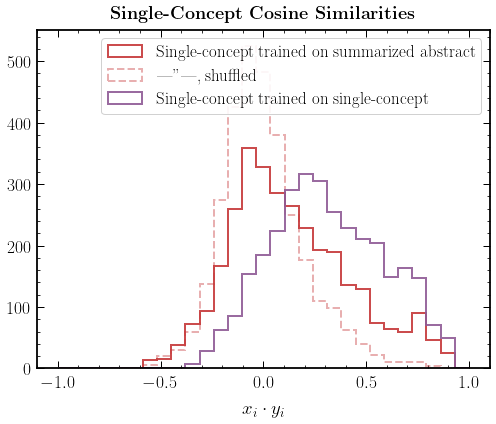

In [84]:
bins = np.linspace(-1, 1, 30)
lw = 2

fig, ax = plt.subplots(1, 1, figsize=(7, 6))

ax.hist(jax.vmap(cosine_similarity)(np.vstack(image_feat_stack), np.vstack(captions_feat_stack)[:]), histtype='step', label="Single-concept trained on summarized abstract", bins=bins, lw=lw)
ax.hist(jax.vmap(cosine_similarity)(np.vstack(image_feat_stack), jax.random.permutation(jax.random.PRNGKey(42), np.vstack(captions_feat_stack)[:])), histtype='step', bins=bins, lw=lw, ls='--', alpha=0.4, label=r"---''---, shuffled", color=cols_default[0])
ax.hist(jax.vmap(cosine_similarity)(np.vstack(image_feat_sum1_stack), np.vstack(captions_feat_sum1_stack)[:]), histtype='step', label="Single-concept trained on single-concept", bins=bins, lw=lw, color=cols_default[3])

ax.legend(frameon=True, framealpha=0.9)
ax.set_title(r"\textbf{Single-Concept Cosine Similarities}", y=1.01)
ax.set_xlabel("$x_i\cdot y_i$")

plt.tight_layout()
plt.savefig("../paper/plots/sim_summ1.pdf")